# Explore SDSSRM-XCS Scatter: $M_{\rm{tot}}$-$M_{\rm{gas}}$ mass dependent scatter

This section of the project explores potential reasons and diagnostics of galaxy cluster/group scaling relation scatter using the new SDSSRM-XCS relations constructed in this work from the properties measured in the first paper of this series [(Turner et al. 2024)](https://ui.adsabs.harvard.edu/abs/2025MNRAS.tmp...10T/abstract).

Here we perform a very simple investigation of a possible dividing line in $M_{\rm{gas}}$ evident in the $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$ relation, between higher mass clusters whose $M_{\rm{tot}}$ and $M_{\rm{gas}}$ appear tightly correlated, and those that do not. We split the dataset into two samples (above and below $M^{\rm{gas}}_{2500}=2\times10^{13}\:M_{\rm{\odot}}$), and fit two separate relations - the measured scatter of each allows us to quantify the difference above and below the $M^{\rm{gas}}_{2500}$ line.

Scaling relation fits were performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details.

## Main takeaways

In summary:

* We split SDSSRM-XCS galaxy clusters with $M^{\rm{tot}}_{2500}$ and $M^{\rm{gas}}_{2500}$ measurements into two samples - above and below $M^{\rm{gas}}_{2500}=2\times10^{13}\:M_{\rm{\odot}}$. $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$ scaling relations are fit to both sub-samples in order to assess any difference in scatter.
* There is a very significant difference in the measured scatter between the two sub-samples; the scatter of clusters $M^{\rm{gas}}_{2500}<2\times10^{13}\:M_{\rm{\odot}}$ is $\mathbf{{\sim}2.4\times}$ larger than that measured for $M^{\rm{gas}}_{2500}\ge2\times10^{13}\:M_{\rm{\odot}}$.

## Import Statements 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
import pickle
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs_cosmo, m_norm, mgas_norm

import xga
from xga.relations.fit import scaling_relation_lira

# Setting up this constant that controls the confidence intervals calculated for the scatter change
#  distributions - makes it much easier to change the exact value later if we need too. This is 
#  what is going to be used to define the scatter-dominating clusters.
CONF_PERC = 90

## Loading data files and relations

We load the 'base' SDSSRM-XCS sample file, containing some basic information about galaxy cluster names, positions, and redshifts. We also load the SDSSRM-XCS cluster property results files from the first paper of this series. 

The scaling relations which we are performing our bootstrapping scatter assessment on are also loaded in here.

### SDSSRM-XCS base sample

In [2]:
sdssxcs_base = pd.read_csv("../../sample_files/SDSSRM-XCS_base_sample.csv")
sdssxcs_base.head(6)

,name,MEM_MATCH_ID,xapa_ra,xapa_dec,rm_ra,rm_dec,z,r500,r500-,r500+,richness,richness_err,XCS_NAME,R_LAMBDA,xmm_targeted,xmm_serendipitous
0,SDSSXCS-124,124,0.80058,-6.09182,0.798261,-6.091694,0.2475,1181.028,21.202,23.203,109.550,4.490,XMMXCS J000312.1-060530.5,1.018410,True,False
1,SDSSXCS-2789,2789,0.95554,2.06802,0.956981,2.066469,0.1053,1007.861,17.194,17.202,38.904,2.830,XMMXCS J000349.3+020404.8,0.827942,True,False
2,SDSSXCS-290,290,2.72264,29.16102,2.714137,29.161154,0.3485,913.052,30.879,31.210,105.096,5.994,XMMXCS J001053.4+290939.6,1.009990,True,False
3,SDSSXCS-1018,1018,4.40633,-0.87619,4.406711,-0.878340,0.2144,902.259,22.445,23.366,56.997,3.219,XMMXCS J001737.5-005234.2,0.893655,False,True
4,SDSSXCS-134,134,4.90839,3.60982,4.911069,3.599257,0.2773,1123.321,19.219,19.226,108.604,4.792,XMMXCS J001938.0+033635.3,1.016645,True,False
5,SDSSXCS-119,119,8.46470,-7.86290,8.471426,-7.869543,0.3042,944.275,46.422,46.747,128.192,5.697,XMMXCS J003351.5-075146.4,1.050926,True,False


Calculating E(z) values for these clusters:

In [3]:
sdssxcs_base['E'] = xcs_cosmo.efunc(sdssxcs_base['z'].values)

### SDSSRM-XCS $T_{\rm{X}}$ and $L_{\rm{X}}$

In [4]:
sdssxcs_txlx = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_txlx_v1.0.0.csv")
sdssxcs_txlx.head(6)

,name,Tx_500,Tx_500-,Tx_500+,Lx52_500,Lx52_500-,Lx52_500+,Lxbol_500,Lxbol_500-,Lxbol_500+,Tx_2500,Tx_2500-,Tx_2500+,Lx52_2500,Lx52_2500-,Lx52_2500+,Lxbol_2500,Lxbol_2500-,Lxbol_2500+,Tx_500ce,Tx_500ce-,Tx_500ce+,Lx52_500ce,Lx52_500ce-,Lx52_500ce+,Lxbol_500ce,Lxbol_500ce-,Lxbol_500ce+
0,SDSSXCS-124,6.92000,0.116389,0.111642,5.310408e+44,2.494586e+42,3.193270e+42,2.039754e+45,2.082091e+43,1.712354e+43,7.08946,0.097823,0.097929,4.008461e+44,2.163312e+42,1.887667e+42,1.557705e+45,1.278003e+43,1.166420e+43,6.78098,0.134306,0.158223,3.684827e+44,2.702225e+42,2.572964e+42,1.401501e+45,1.425781e+43,1.280567e+43
1,SDSSXCS-2789,4.54033,0.073600,0.074023,1.029575e+44,5.149604e+41,6.858712e+41,3.213527e+44,3.914562e+42,3.124017e+42,4.44237,0.057404,0.057774,7.125319e+43,4.164749e+41,3.793543e+41,2.201238e+44,1.767406e+42,1.642524e+42,4.65452,0.108600,0.113677,6.943669e+43,6.482835e+41,5.773788e+41,2.192642e+44,2.960496e+42,2.652251e+42
2,SDSSXCS-290,5.31681,0.297854,0.336308,2.856695e+44,5.917234e+42,7.322989e+42,9.632533e+44,4.005991e+43,3.207763e+43,5.41431,0.259989,0.309605,2.033267e+44,4.662931e+42,4.169953e+42,6.920658e+44,2.211700e+43,1.983518e+43,5.44819,0.407899,0.486340,1.972104e+44,6.434636e+42,6.092122e+42,6.734043e+44,3.038773e+43,2.687861e+43
3,SDSSXCS-1018,3.90154,0.143544,0.151498,8.044819e+43,1.441322e+42,9.241468e+41,2.335851e+44,6.385493e+42,4.924304e+42,4.09555,0.108381,0.115430,6.395952e+43,8.467201e+41,7.602523e+41,1.899850e+44,3.436098e+42,3.542190e+42,3.93098,0.207281,0.230478,5.048987e+43,1.253282e+42,1.066663e+42,1.471118e+44,5.740520e+42,4.871391e+42
4,SDSSXCS-134,6.72622,0.116523,0.116565,4.811899e+44,2.458557e+42,3.050440e+42,1.825296e+45,2.068757e+43,1.639058e+43,7.04643,0.104430,0.104760,3.813160e+44,2.170963e+42,1.872005e+42,1.479760e+45,1.263153e+43,1.208755e+43,6.37686,0.135837,0.153820,3.447715e+44,2.713877e+42,2.497416e+42,1.273855e+45,1.415497e+43,1.228583e+43
5,SDSSXCS-119,4.93456,0.400268,0.456173,2.049789e+44,5.182032e+42,6.885075e+42,6.654626e+44,4.141700e+43,3.282061e+43,5.41255,0.397709,0.448294,1.239172e+44,3.785057e+42,3.735144e+42,4.215892e+44,2.155310e+43,1.870703e+43,4.91222,0.432241,0.503558,1.821676e+44,5.522211e+42,5.714386e+42,5.900648e+44,3.822404e+43,2.772960e+43


### SDSSRM-XCS masses

In [5]:
sdssxcs_mass = pd.read_csv("../../sample_files/paper_one_results/sdssrm-xcs_mass_v1.0.0.csv")
sdssxcs_mass.head(6)

,name,Mhy500,Mhy500-,Mhy500+,Mg500,Mg500-,Mg500+,Mhy2500,Mhy2500-,Mhy2500+,Mg2500,Mg2500-,Mg2500+,Mhy500_wraderr,Mhy500_wraderr-,Mhy500_wraderr+,Mg500_wraderr,Mg500_wraderr-,Mg500_wraderr+,Mhy2500_wraderr,Mhy2500_wraderr-,Mhy2500_wraderr+,Mg2500_wraderr,Mg2500_wraderr-,Mg2500_wraderr+
0,SDSSXCS-124,7.634491,1.286289,1.029318,0.869914,0.002841,0.005951,2.621329,0.112240,0.137975,0.321744,0.000722,0.000734,7.635562,1.285474,1.041261,0.870390,0.015662,0.016223,2.621462,0.113380,0.138668,0.321697,0.007076,0.007250
1,SDSSXCS-2789,7.820374,1.259755,1.447212,0.218603,0.002491,0.002496,1.602926,0.101929,0.109311,0.097414,0.000324,0.000329,7.823912,1.268244,1.456225,0.218499,0.002874,0.002963,1.602810,0.102195,0.110153,0.097399,0.001819,0.001737
2,SDSSXCS-290,2.961604,0.369827,0.382523,0.427969,0.002132,0.002098,1.467429,0.175603,0.290465,0.134154,0.000759,0.000773,2.959792,0.390293,0.420849,0.427478,0.019454,0.019887,1.469441,0.177871,0.288247,0.134133,0.005839,0.005993
3,SDSSXCS-1018,5.067958,1.015270,0.969362,0.210208,0.001929,0.001917,1.128892,0.103503,0.149913,0.084371,0.000350,0.000359,5.072697,1.030805,0.973924,0.210059,0.003374,0.003431,1.128619,0.104011,0.149860,0.084350,0.002327,0.002330
4,SDSSXCS-134,6.802619,0.782566,0.772819,0.767290,0.002149,0.002170,3.043225,0.113304,0.110341,0.313945,0.000359,0.000367,6.803511,0.788996,0.781372,0.767157,0.010866,0.010814,3.042067,0.125878,0.124549,0.313911,0.007265,0.007068
5,SDSSXCS-119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Combining tables

In [6]:
sdssxcs_samp = pd.merge(sdssxcs_base, sdssxcs_txlx, left_on='name', right_on='name', how='outer')
sdssxcs_samp = pd.merge(sdssxcs_samp, sdssxcs_mass, left_on='name', right_on='name', how='outer')

### $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$

In [7]:
with open('../../outputs/scaling_relations/sdssrm-xcs_new/mtot-mgas/scatter_dominating_excluded/'\
          'turner2025_scatter-dom-exc_mtot2500_mgas2500.xgarel', 'rb') as scalo:
    mtot2500_mgas2500 = pickle.load(scalo)

## Splitting the dataset

We split the dataset in two, so that both subsets can be fit with scaling relations separately in order to assess their relative scatter.

In [8]:
mgas_split = Quantity(2.e+13, 'Msun')

### Removing scatter-dominating clusters

In the jackknifing analysis of the new SDSSRM-XCS $M_{\rm{tot}}$-$M_{\rm{gas}}$ relations, we identified galaxy clusters with an outsize contribution to the overall measured scatter of the relations ('scatter dominating clusters'). In order to get the clearest answer as to whether there is a change in scatter depending on the gas mass, we will exclude the scatter dominating datapoints. 

The jackknifing results for the $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$ are loaded in:

In [9]:
l1_mtot2500_mgas2500_res = pd.read_csv("../../outputs/result_files/exploring_scatter/leave_one_jackknife"\
                                       "/mtot-mgas/mtot2500_mgas2500_l1_jackknife_rel_pars.csv")
l1_mtot2500_mgas2500_res

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
0,SDSSXCS-1018,0.5748,0.0454,1.3454,0.0547,0.1510,0.0138,0.733
1,SDSSXCS-10401,0.5581,0.0449,1.3603,0.0540,0.1464,0.0135,-2.373
2,SDSSXCS-110,0.5702,0.0449,1.3363,0.0533,0.1483,0.0136,-1.117
3,SDSSXCS-11154,0.5749,0.0452,1.3496,0.0545,0.1501,0.0137,0.093
4,SDSSXCS-1131,0.5749,0.0452,1.3454,0.0544,0.1505,0.0137,0.402
...,...,...,...,...,...,...,...,...
86,SDSSXCS-907,0.5757,0.0457,1.3448,0.0545,0.1511,0.0138,0.765
87,SDSSXCS-9258,0.5890,0.0462,1.3347,0.0540,0.1495,0.0136,-0.289
88,SDSSXCS-9313,0.5763,0.0458,1.3427,0.0548,0.1511,0.0138,0.766
89,SDSSXCS-944,0.5728,0.0455,1.3479,0.0546,0.1505,0.0137,0.391


Identifying scatter-dominating clusters using the same confidence limit as the 'dominating excluded' scaling relations:

In [10]:
cur_low = np.percentile(l1_mtot2500_mgas2500_res['scatter_perc_change'].values, (50-(CONF_PERC/2)))

l1_mtot2500_mgas2500_domin = l1_mtot2500_mgas2500_res[l1_mtot2500_mgas2500_res['scatter_perc_change'] < cur_low]
l1_mtot2500_mgas2500_domin

,dropped_cluster,slope,slope+-,norm,norm+-,scatter,scatter+-,scatter_perc_change
19,SDSSXCS-176,0.5924,0.0445,1.3279,0.0523,0.1449,0.0134,-3.383
55,SDSSXCS-457,0.5830,0.0442,1.3565,0.0534,0.1455,0.0134,-2.935
60,SDSSXCS-5159,0.6121,0.0451,1.3219,0.0517,0.1432,0.0129,-4.490
61,SDSSXCS-5225,0.5684,0.0438,1.3610,0.0532,0.1445,0.0134,-3.644
82,SDSSXCS-8060,0.5980,0.0439,1.3245,0.0514,0.1421,0.0132,-5.226


Removing those clusters from our dataset:

In [11]:
dom_excl_sdssxcs_samp = sdssxcs_samp[(~sdssxcs_samp['name'].isin(l1_mtot2500_mgas2500_domin['dropped_cluster'].values)) & 
                                     (sdssxcs_samp['name'].isin(l1_mtot2500_mgas2500_res['dropped_cluster'].values))]

### Splitting the sample

In [12]:
above_samp = dom_excl_sdssxcs_samp[Quantity(dom_excl_sdssxcs_samp['Mg2500_wraderr']*1e+14, 'Msun') >= mgas_split]
below_samp = dom_excl_sdssxcs_samp[Quantity(dom_excl_sdssxcs_samp['Mg2500_wraderr']*1e+14, 'Msun') < mgas_split]

## Fitting the relations

We can now fit the two sub-samples in exactly the same way as the original scaling relation was constructed.

### $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$ [$M^{\rm{gas}}_{2500}\ge2\times10^{13}\:M_{\odot}$]

In [13]:
# Setting up property variables in astropy quantity objects
mtot2500 = Quantity(above_samp[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']].values*1e+14, 'Msun')
mgas2500 = Quantity(above_samp[['Mg2500_wraderr', 'Mg2500_wraderr-', 'Mg2500_wraderr+']].values*1e+14, 'Msun')

mtot2500_mgas2500_above = scaling_relation_lira(mtot2500[:, 0], mtot2500[:, 1:], mgas2500[:, 0], mgas2500[:, 1:], m_norm, 
                                                mgas_norm, y_name=r"$M^{\rm{tot}}_{2500}$", x_name=r"$M^{\rm{gas}}_{2500}$", 
                                                point_names=above_samp['name'].values)
mtot2500_mgas2500_above.model_colour = 'goldenrod'
mtot2500_mgas2500_above.author = 'Turner et al.'
mtot2500_mgas2500_above.year = 2025
mtot2500_mgas2500_above.name = r"$M^{\rm{gas}}_{2500} \geq 2\times10^{13}\:M_{\odot}$"

R[write to console]: module mix loaded



  |**************************************************| 100%


In [14]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_mgas2500_above.pars[0][0], e=mtot2500_mgas2500_above.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_mgas2500_above.pars[1][0], e=mtot2500_mgas2500_above.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_mgas2500_above.scatter_par[0], e=mtot2500_mgas2500_above.scatter_par[1]))

Slope of 0.720 ± 0.099

Normalisation of 1.289 ± 0.148

Scatter of 0.057 ± 0.011


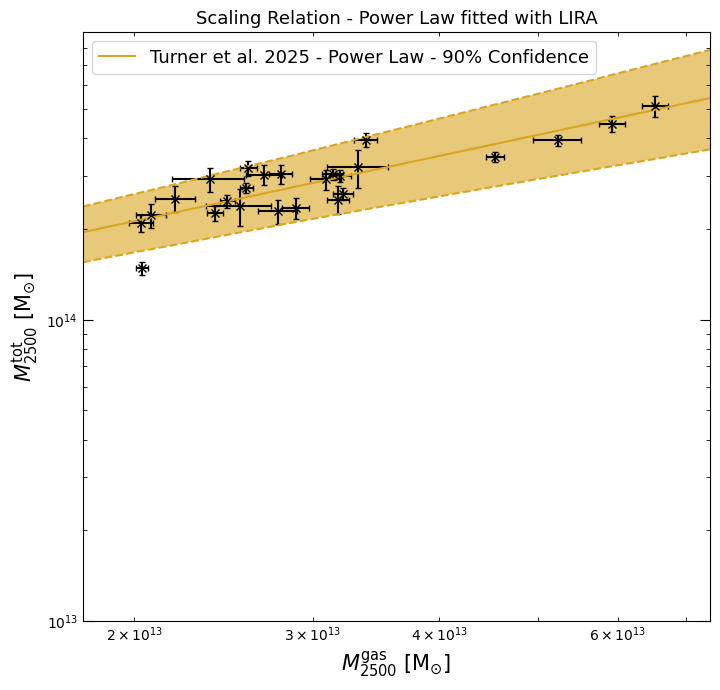

In [15]:
mtot2500_mgas2500_above.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

### $M^{\rm{tot}}_{2500}$-$M^{\rm{gas}}_{2500}$ [$M^{\rm{gas}}_{2500}\lt2\times10^{13}\:M_{\odot}$]

In [16]:
# Setting up property variables in astropy quantity objects
mtot2500 = Quantity(below_samp[['Mhy2500_wraderr', 'Mhy2500_wraderr-', 'Mhy2500_wraderr+']].values*1e+14, 'Msun')
mgas2500 = Quantity(below_samp[['Mg2500_wraderr', 'Mg2500_wraderr-', 'Mg2500_wraderr+']].values*1e+14, 'Msun')

mtot2500_mgas2500_below = scaling_relation_lira(mtot2500[:, 0], mtot2500[:, 1:], mgas2500[:, 0], mgas2500[:, 1:], m_norm, 
                                                mgas_norm, y_name=r"$M^{\rm{tot}}_{2500}$", x_name=r"$M^{\rm{gas}}_{2500}$", 
                                                point_names=below_samp['name'].values)
mtot2500_mgas2500_below.model_colour = 'darkcyan'
mtot2500_mgas2500_below.author = 'Turner et al.'
mtot2500_mgas2500_below.year = 2025
mtot2500_mgas2500_below.name = r"$M^{\rm{gas}}_{2500}<2\times10^{13}\:M_{\odot}$"

  |**************************************************| 100%


In [17]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_mgas2500_below.pars[0][0], e=mtot2500_mgas2500_below.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=mtot2500_mgas2500_below.pars[1][0], e=mtot2500_mgas2500_below.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=mtot2500_mgas2500_below.scatter_par[0], e=mtot2500_mgas2500_below.scatter_par[1]))

Slope of 0.580 ± 0.072

Normalisation of 1.250 ± 0.061

Scatter of 0.137 ± 0.016


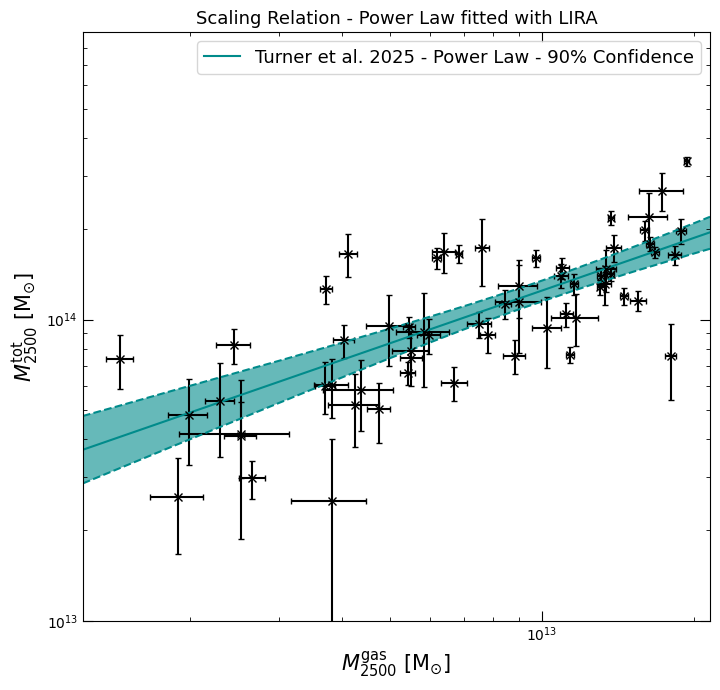

In [18]:
mtot2500_mgas2500_below.view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'))

## Visualising the scaling relations

Our main goal here was to quantify the difference in scatter between the two sub-samples, but we also compare the two by visualising them in a single figure.

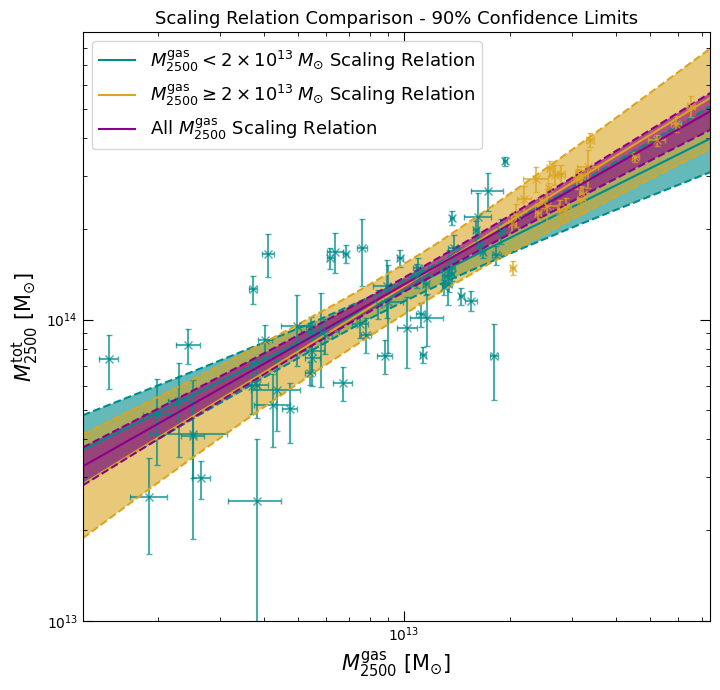

In [19]:
# Stupid bodge to make the relation figure labels plot properly
mtot2500_mgas2500_below.author = 'XGA'
mtot2500_mgas2500_above.author = 'XGA'
mtot2500_mgas2500.author = 'XGA'
# Modifying the loaded mtot2500-mgas2500 relation so it won't show any data points
mtot2500_mgas2500.name = r'All $M^{\rm{gas}}_{2500}$'

(mtot2500_mgas2500_below + mtot2500_mgas2500_above + 
     mtot2500_mgas2500).view(figsize=(7.3, 7), y_lims=Quantity([1e+13, 9e+14], 'Msun'), 
                             save_path="../../outputs/figures/exploring_scatter/mtot2500_mgas2500_scatter_mgas_dep.pdf",
                             data_colour_list=[mtot2500_mgas2500_below.model_colour,
                                               mtot2500_mgas2500_above.model_colour,
                                               'None'])

mtot2500_mgas2500_below.author = 'Turner et al.'
mtot2500_mgas2500_above.author = 'Turner et al.'
mtot2500_mgas2500.author = 'Turner et al.'

We also make a corner plot with both relations:

Removed no burn in
Removed no burn in
Removed no burn in


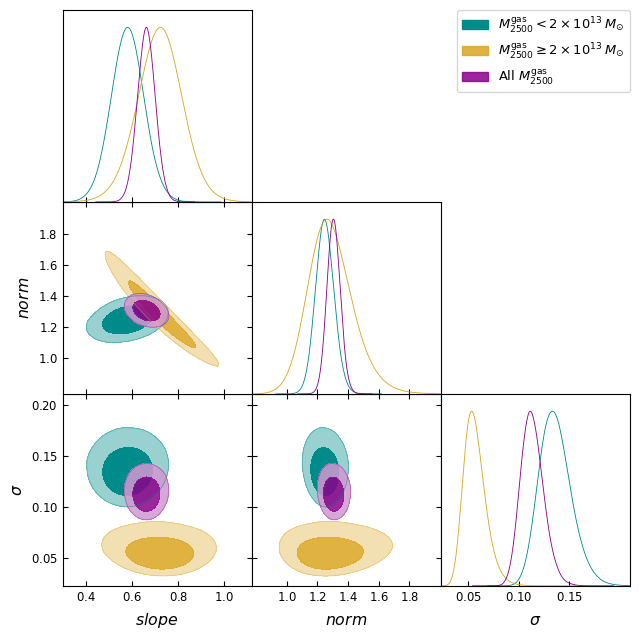

In [20]:
(mtot2500_mgas2500_below + mtot2500_mgas2500_above + mtot2500_mgas2500).view_corner(figsize=(6.5, 6.5), 
                                                                save_path="../../outputs/figures/exploring_scatter/"\
                                                                          "mtot2500_mgas2500_scatter_mgas_dep_contours.pdf")